# Train and Tune / Recursive Single-Step

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import optuna.visualization as vis
import pandas as pd

from src.config import Config
from src.data import time_series_split
from src.models.classical import LinearElasticNet
from src.plots import plot_price_overlay, plot_price_overlay_next_30
from src.preprocessing import get_preprocessor
from src.recursive import RecursiveForecaster
from src.train import ModelTrainer
from src.utils import load_csv, set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
rng = set_seed(cfg.runtime.seed)
horizon_1 = 1
horizon_30 = 30

2025-08-19 12:30:23,508 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = load_csv(Path(cfg.data.processed_dir) / cfg.data.name_features_full)

In [4]:
train, val, test, forecast = time_series_split(df_full, train_ratio=0.8, val_ratio=0.1, horizon=horizon_30)

In [5]:
drop_cols = ["open", "high", "low", "close", "volume", "adj_close"]
target_cols = [c for c in df_full.columns if c == "target" or c.startswith("target_")]
feature_cols = [c for c in df_full.columns if c not in target_cols + ["date"] + drop_cols]

single_target = "target" if "target" in train.columns else "target_1"

X_train, y_train = train[feature_cols], train[[single_target]]
X_val, y_val = val[feature_cols], val[[single_target]]
X_test, y_test = test[feature_cols], test[[single_target]]

In [6]:
X_test.to_parquet(Path(cfg.data.processed_dir) / "X_test_1.parquet", index=False)

In [7]:
preprocessor, _ = get_preprocessor(X_train)

In [8]:
model = LinearElasticNet(
    horizon=horizon_1,
    multioutput=False,
    random_state=cfg.runtime.seed,
    max_iter=2000
)

trainer = ModelTrainer(
    model=model,
    name="enet_mo_1",
    config={"optimization_metric": "rmse", "gap": 0},
    preprocessor=preprocessor,
    y_scale=True
)

2025-08-19 12:30:23,576 - INFO - ModelTrainer - Initialized ModelTrainer for model: enet_mo_1


In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda t: trainer.objective(t, X_train, y_train, n_splits=3), n_trials=20)
best_params = study.best_trial.user_attrs.get("best_params", {})
trainer.fit(X_train, y_train, X_val, y_val, best_params=best_params)

[I 2025-08-19 12:30:23,587] A new study created in memory with name: no-name-b40f9acf-8d0a-4ba3-881e-ec37bb311613
[I 2025-08-19 12:30:23,638] Trial 0 finished with value: 0.009970948995634431 and parameters: {'alpha': 0.0020126159430925734, 'l1_ratio': 0.7558081778987198, 'selection': 'cyclic'}. Best is trial 0 with value: 0.009970948995634431.
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e+00, tolerance: 3.880e-02
  model = cd_fast.enet_coordinate_descent(
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+00,

In [10]:
best_model = LinearElasticNet(horizon=horizon_1, **best_params)
trainer = ModelTrainer(best_model, name="enet_mo_1", config=best_params, preprocessor=preprocessor)
trainer.fit(X_train, y_train)

2025-08-19 12:30:24,692 - INFO - ModelTrainer - Initialized ModelTrainer for model: enet_mo_1
2025-08-19 12:30:24,692 - INFO - ModelTrainer - Starting model training...


In [11]:
print("train:", trainer.evaluate(X_train, y_train))
print("val  :", trainer.evaluate(X_val, y_val))
print("test :", trainer.evaluate(X_test, y_test))

2025-08-19 12:30:24,706 - INFO - ModelTrainer - Evaluating model...
2025-08-19 12:30:24,733 - INFO - ModelTrainer - Evaluating model...
2025-08-19 12:30:24,737 - INFO - ModelTrainer - Evaluating model...


train: {'mae': 0.00832808698183925, 'mse': 0.00017557412560951694, 'rmse': 0.013250438694983534, 'smape': 1.7904197822148713, 'r2': 0.0070674753322894635}
val  : {'mae': 0.005782411994355792, 'mse': 5.941541900359507e-05, 'rmse': 0.00770813978879438, 'smape': 1.7763069343732265, 'r2': 0.0039889549837553995}
test : {'mae': 0.008231181354023351, 'mse': 0.00012038771734636927, 'rmse': 0.010972133673373163, 'smape': 1.8132872725536042, 'r2': -0.0012181656650396278}


In [12]:
model_path = trainer.save()

In [13]:
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()

## Recursive

In [14]:
MODEL_PATH = Path(cfg.model.path_dir) / cfg.model.enet_mo_best_1
model, preprocessor, y_scaler, _ = ModelTrainer.load(str(MODEL_PATH))

price_cols = ["date", "open", "high", "low", "close", "adj_close", "volume"]
price_df = df_full[price_cols].dropna(subset=["date", "adj_close"]).copy()

news_df = pd.DataFrame()

forecaster = RecursiveForecaster(
    model,
    preprocessor,
    y_scaler,
    sentiment_model=None)

lr_path = forecaster.forecast(
    price_df=price_df,
    news_df=news_df,
    horizon=horizon_30
)

start_price = float(price_df["adj_close"].iloc[-1])
price_path = start_price * np.exp(np.cumsum(lr_path))

pd.DataFrame({"h": np.arange(1, horizon_30 + 1), "log_return": lr_path, "price": price_path}).head()

,h,log_return,price
0,1,0.000045,17950.182363
1,2,0.000146,17952.804738
2,3,0.000198,17956.360590
3,4,0.000232,17960.528777
4,5,0.000254,17965.095964


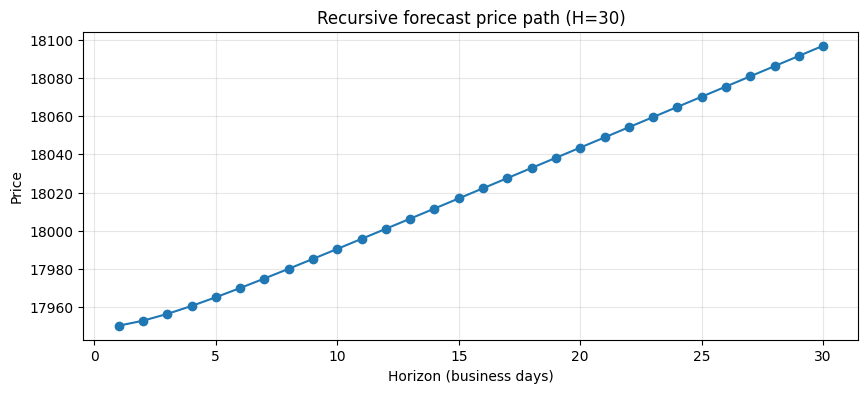

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, horizon_30 + 1), price_path, marker="o")
plt.title(f"Recursive forecast price path (H={horizon_30})")
plt.xlabel("Horizon (business days)")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

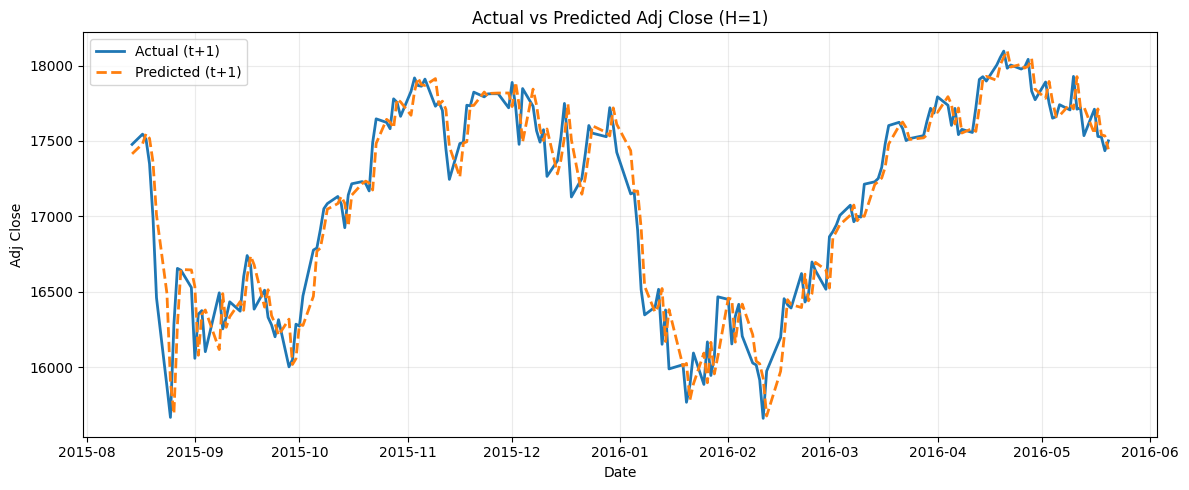

In [16]:
y_pred = trainer.predict(X_test)
y_pred = np.asarray(y_pred).reshape(-1, 1)

plot_price_overlay(
    df_full,
    X_test=X_test,
    y_pred=y_pred,
    path=Path(cfg.data.fig_dir) / "recursive_pred_vs_actual_adj_close_price_plus_1.png",
)

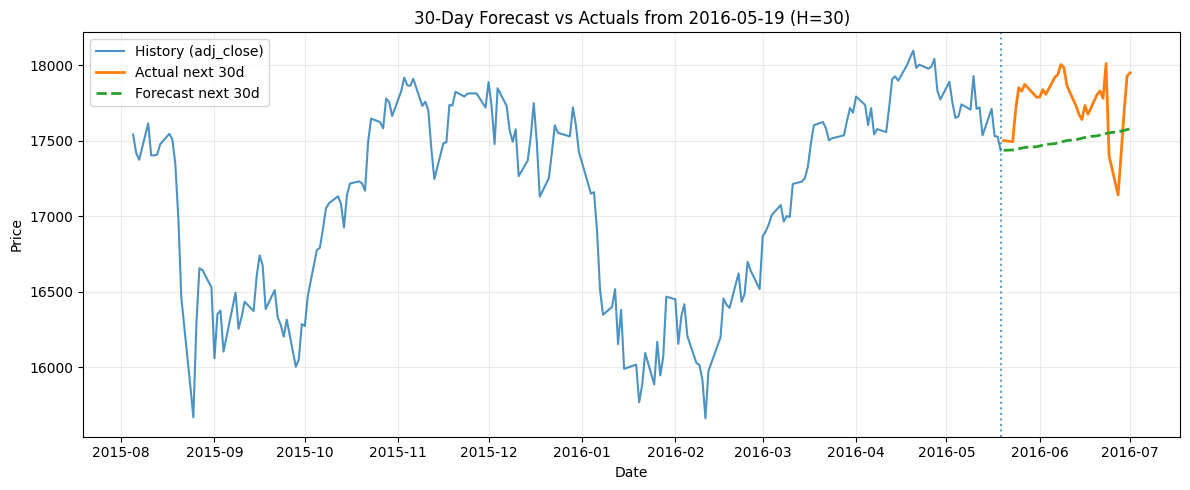

In [17]:
anchor_idx = df_full.shape[0] - horizon_30 - 1

plot_price_overlay_next_30(
    df_full,
    lr_path=lr_path,
    anchor_idx=anchor_idx,
    horizon=len(lr_path),
    hist_window=200,
    path=Path(cfg.data.fig_dir) / "recursive_pred_vs_actual_adj_close_plus_30.png",
)